# Mask statistics (regionprops) #
This notebook shows how can we extract statistical information from an image (e.g. finding the maximal intensity in a desired region of interest). The steps that we need to follow to achieve this mainly depend on the exact problem we want to solve but in general it consists of: 

    Step 1: load and read the image (load-data.ipynb)
    Step 2: pre-process the image if necessary such as noise filtering (filter-image.ipynb)
    Step 3: find the region of interest: edge or inside the region? 
    Step 4: extract the desired information in the region of interest: mean, max, min, sum, median, mode, ...
    Step 5: display/plot results
    Step 6: save the result in a given image format or values in a text/excel file

## I. Load image ##

In [22]:
# LOAD PACKAGES
from scyjava import config          # for AICSImage
from aicsimageio import AICSImage   # for reading the image
import numpy as np                  # for operations on arrays
import matplotlib.pyplot as plt     # for plotting/display 
import cv2                          # for generating random noise with a given distribution

In [23]:
# LOAD DATA
mydata=AICSImage("C:/Users/Dina Ratsimandresy/Documents/MRC-Office/Dataset/PythonCourse precious images/Airy_4color_40nm_67e5micron_diversoformato-confocal.tif")
myimg = mydata.data[0,:,0,:,:]  # select all channels at t = 0 and z = 0
imgsize = myimg.shape           # image size

## II. Display the image ##

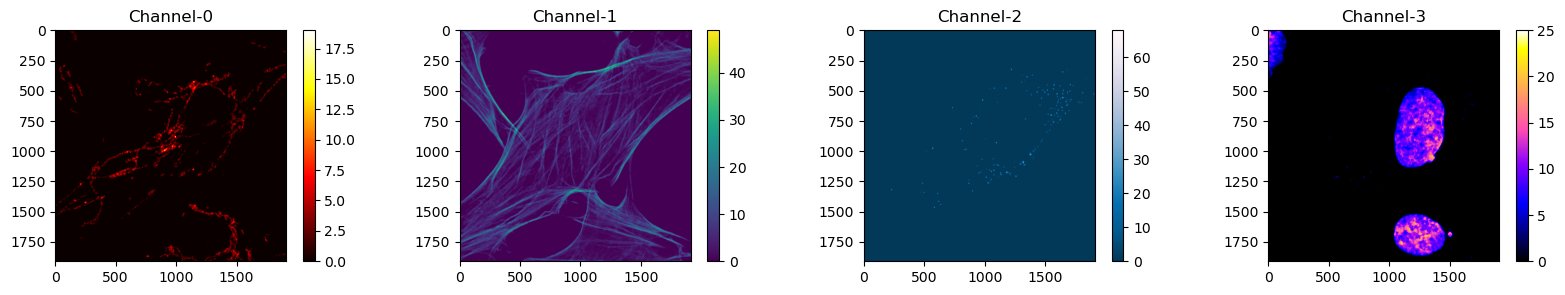

In [24]:
# define the colormap
cmpsuggestion=['hot','viridis','PuBu_r','gnuplot2']
# display each channel
fig, axs = plt.subplots(1, 4)
for k in range(4):
    ax1=axs[k].imshow(myimg[k,:,:], plt.colormaps[cmpsuggestion[k]])    
    axs[k].set_title('Channel-'+str(k))
    plt.colorbar(ax1,ax=axs[k]) 
fig.set_size_inches(20, 3)

# display the combined channel

## III. Define the problem ##
We need to define a problem here. Let say we are interested in what is happening in each channel within the actin region (Channel-1) that surround each nucleus (Channel-3). Our region of interest (ROIs) are therefore defined by the regions delimited by the actins in Channel-1 that have as a "seed" the nuclei in Channel-3. We want to measure:
- the maximal intensity in Channel-0 within each ROI,
- the integrated intensity in Channel-1 within each ROI,
- the median intensity of Channel-2 within each ROI  
- the number of dots in Channel-2 within each ROI

That is enough problem for now so let's get into it :)

To solve the problem and achieve the statistic analysis, we firstly need to find the region where the nuclei are and used these regions as markers. Secondly, we find the actins associated with each of the nucleus marker. We should expect to have two distincts ROIs then from the data we have here. We do the measurements of the abovementioned intensity within each ROI afterwards. 

## IV. Segmentation of the region of interest (ROI) ##
The goal is to find masks which represents each ROI. The easiest way to do this by simply thresholding the intensity of the image. By this, the mask is defined such that only intensity (pixel) values greater than the threshold value are selected. If we stop at this stage, the problem we may encounter is such that some values within the thresholded region may get discarded because the intensity value is lower than the threshold and the ROI won't be filled. In this case, we may need to find the edge or/and fill the mask region. Another issue that we may encounter as well is that the edges of the regions may overlap so they may be detected or segmented as one. One solution in this case is to use what is called watershed segmentation to detect the flow of the intensity and decide from there whether the regions form only one object or different objects. 

## IV.1. Thresholding ##

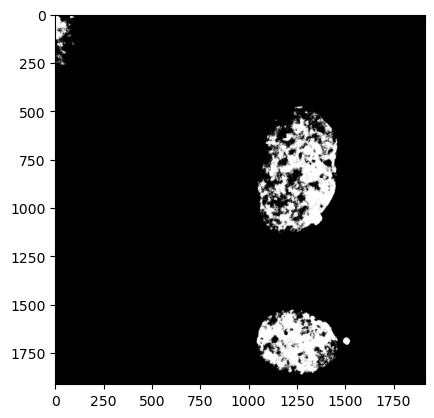

In [25]:
nuclei=myimg[3,:,:] # the object we want to segment and set as markers of our final ROI
thresholdmask=nuclei>=10 # change threshold value here to see what happens to the thresholdmask that is being displayed below
plt.imshow(thresholdmask,cmap='gray')
plt.show()

## IV.2. Automated thresholding segmentation ##
There is also one way to automatically detect the threshold that needs to be applied on the image in order to detect the nuclei region. This method was developed by Otsu and you can follow the link [here](https://en.wikipedia.org/wiki/Otsu%27s_method) if you want to learn more how does it work. So let us see now how can we do the thresholding using the Otsu's method and fill the mask. And since in microscopic images, we may have more than one nuleus (in our case we do have 2 full ones), we need to label each of the nuclei to distingush them and to be able to extract information from each of them. To achieve these, we need to load some packages first. 

In [42]:
# PACKAGES
from skimage.filters import threshold_otsu                          # Otsu's threshold
from skimage.morphology import closing, square                      # To close the region we just obtained from the thresholding
from skimage.segmentation import clear_border                       # To remove artifacts connected to image border
from skimage.measure import label, regionprops, find_contours       # To label the nucleis, measure information about regions, find the countours of each region
from skimage.color import label2rgb                                 # To attribute colors to the labelled regions
from skimage import morphology                                      # A collection of non-linear operations related to the shape or morphology of features in an image
from scipy import ndimage as ndi                                    # Package contains functions for multidimensional image processing 
from skimage.segmentation import watershed                          # For watershed segmentation
from skimage import measure                                         # For measuring the image properties. Package contains the regionprops function that we will use for statistical analysis in the image
from skimage.feature import blob_dog                                # For blob or spot detection using the difference of Gaussian method

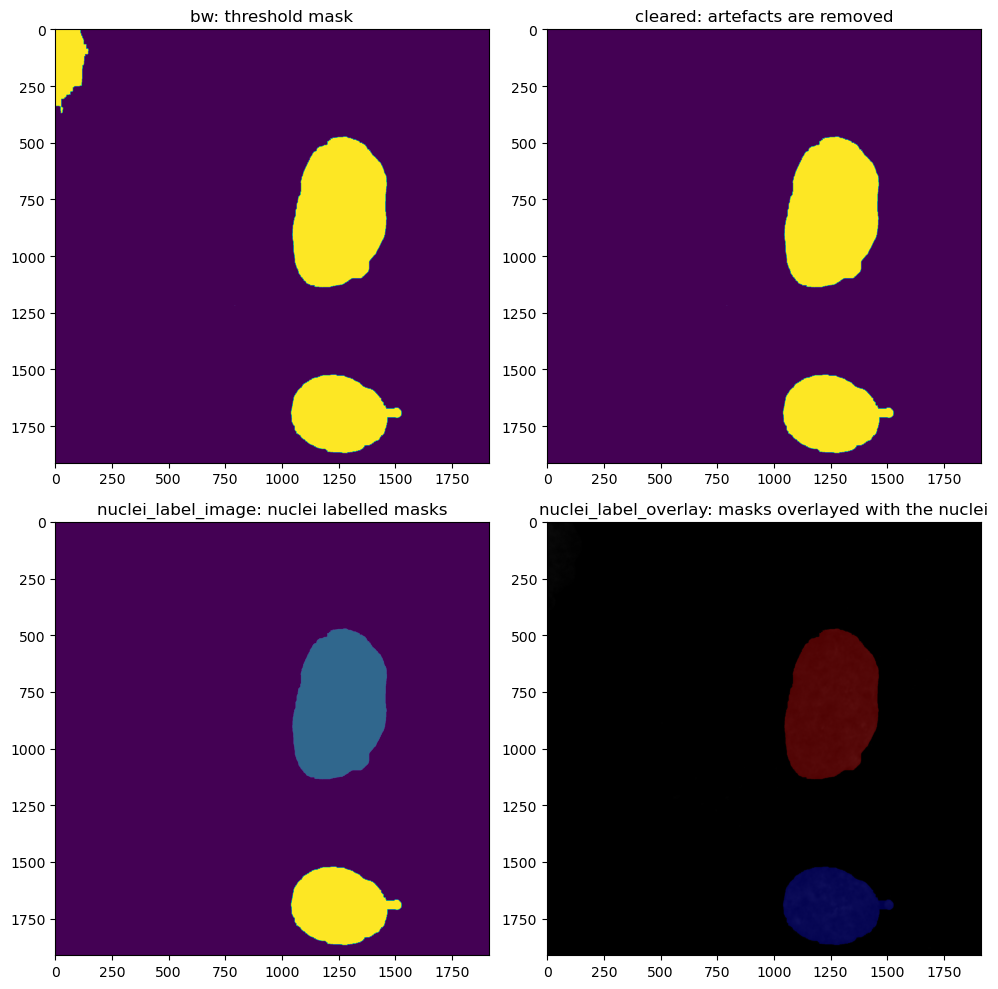

In [27]:
# find the threshold value differentiating the signal from background
thresh = threshold_otsu(nuclei) 

# define the threshold mask and close it
bw = closing(nuclei > thresh, square(35)) 

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
nuclei_label_image = label(cleared) 

# remove small objects that may still be present in the masks and only keep the two biggest regions
props = regionprops(nuclei_label_image, nuclei)   # measure the image properties of the labelled regions within the nuclei
area_labeleled_regions = [p.area for p in props]  # extract the areas of the labelled images
area_labeleled_regions = sorted(area_labeleled_regions) # sort the list of areas so that we can have the two biggest regions at the end of the list
nuclei_label_image = morphology.remove_small_objects(nuclei_label_image, min_size=area_labeleled_regions[-1-2]+1) # remove small objects with size smaller than the defined min_size

# label image to rgb 
nuclei_label_overlay = label2rgb(nuclei_label_image, image=nuclei, bg_label=0)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(bw)
ax[0,0].set_title('bw: threshold mask')

ax[0,1].imshow(cleared)
ax[0,1].set_title('cleared: artefacts are removed')

ax[1,0].imshow(nuclei_label_image)
ax[1,0].set_title('nuclei_label_image: nuclei labelled masks')

ax[1,1].imshow(nuclei_label_overlay)
ax[1,1].set_title('nuclei_label_overlay: masks overlayed with the nuclei')


plt.tight_layout()
plt.show()

## IV.3. Watershed-based segmentation ##
The segmentation of the nuclei is pretty straightforward because they are well separated. In same cases however, the objects we want to segment overlap, making it difficult to discern the different regions. In this case, we would need to add extra step into the image segmentation in order to discern the objects. Watershed segmentation is useful for this purpose. It is generally used for separating different objects. Watershed algorithm treats pixels values as a local topography (elevation) so the goal is to follow the flow of the elevation and find the watershed lines from which the edge of each of the regions are deduced. We use this principle to extract our previously defined ROIs: the actin region in Channel-1 having the two nuclei as markers and the seeds of the segmentation. 

The steps that we need to follow for this are as follows: 
*  Step 1: threshold the actin to segment to obtain a region mask denoted by actin_mask from it
*  Step 2: calculate the distance transform of actin_mask, also known as distance map, which defines the spatial distance of each pixel value position to the background of the image
*  Step 3: define the markers or seeds of the segmentation as local maxima of the distance to the background (local minima of the image to segment and the opposite of the distance). We have this as the nuclei_label_image. 
*  Step 4: watershed the opposite of the distance transform from Step 2 within the mask in Step 1 and the nuclei markers 

Text(0.5, 1.0, 'nuclei as seeds')

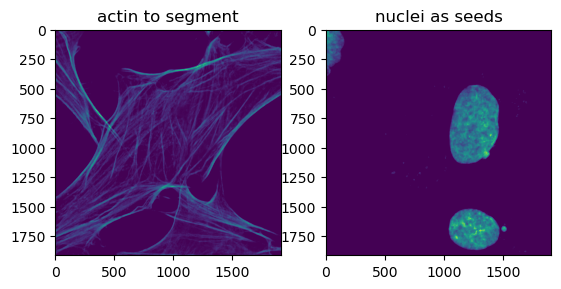

In [28]:
actin = myimg[1,:,:] # the regions we want to segment 
fig, axs = plt.subplots(1,2)
axs[0].imshow(actin)
axs[0].set_title('actin to segment')

axs[1].imshow(nuclei)
axs[1].set_title('nuclei as seeds')


#### IV.3.1. Mask in the actin Channel-1 ####
Create a mask on the actin using thresholding and morphological operations for closing and filling the mask. In the morphological operations, the erosion and dilation operations are used. Erosion removes small objects so only the big objects will remain in the image while dilation makes small objects more visible and fills in small holes in objects. A successive operation of those two operations dilation followed by an erosion constitutes the closing function.

Text(0.5, 1.0, 'filled actin_mask')

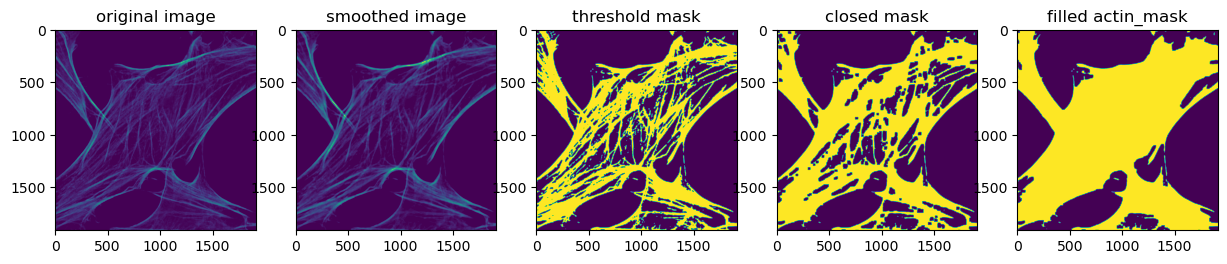

In [29]:
# pre-processing to smooth the image before thresholding

smooth_actin = ndi.gaussian_filter(actin, sigma=3)

# find the optimal threshold
thresh = 1#threshold_otsu(actin) 

# define the threshold mask
thresh_mask = smooth_actin > thresh 

# close the mask using closing function with a defined kernel as the second argument of the function
closed_mask = closing(thresh_mask, square(20)) 

# the mask is not properly filled so fill holes to form the the actin_mask
actin_mask = ndi.binary_fill_holes(closed_mask).astype(int)

fig, axs = plt.subplots(1,5, figsize=(15, 15))
axs[0].imshow(actin)
axs[0].set_title('original image')

axs[1].imshow(smooth_actin)
axs[1].set_title('smoothed image')

axs[2].imshow(thresh_mask)
axs[2].set_title('threshold mask')

axs[3].imshow(closed_mask)
axs[3].set_title('closed mask')

axs[4].imshow(actin_mask)
axs[4].set_title('filled actin_mask')

#### IV.3.2. Change bit depth and mask update ####
The dynamic range of the intensity values of the actin image is low. The image also has a 8 bit depth. Because of these, we needed to do a lot of filtering to smooth the image and still did not obtain a good mask which can accurately covers the actins (see the figure representing the filled and closed mask above). A solution to this can consist of increasing the bit depth, hence the dynamic range, and blurring the image using a Gaussian filter afterwards. We convert the 8-bit image into 32-bit floating point.


In [30]:
print('(min, max) of the dynamic range =', (np.min(actin), np.max(actin)))
print('bit depth: ', actin.dtype)

(min, max) of the dynamic range = (0, 49)
bit depth:  uint8


In [31]:
# convert 8-bit into 32-bit floating point
actin_float = actin.astype(np.float32)
print('bit depth: ', actin_float.dtype)

bit depth:  float32


Text(0.5, 1.0, 'filled actin_mask')

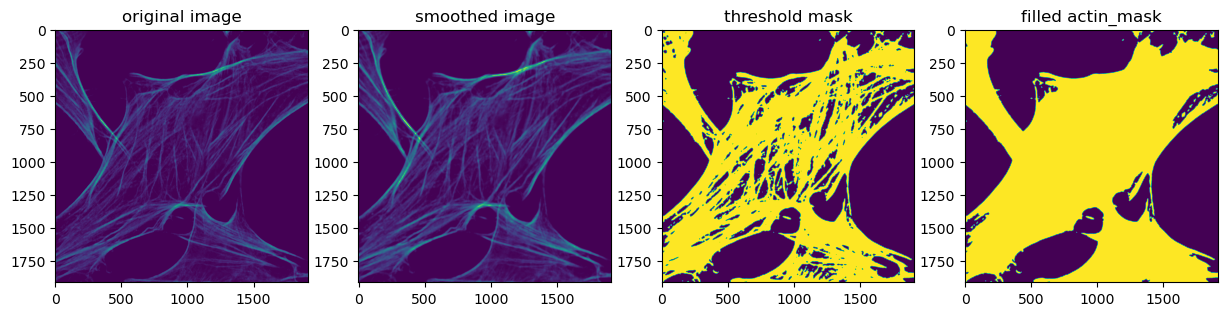

In [32]:
# smoothed the image using the Gaussian filter with the same sigma as before
smooth_actin = ndi.gaussian_filter(actin_float, sigma=3)
# find the optimal threshold
thresh = 1#threshold_otsu(actin) 

# define the threshold mask
thresh_mask = smooth_actin > thresh 

# fill holes to form the the actin_mask without performing the closing function
actin_mask = ndi.binary_fill_holes(thresh_mask).astype(int)

fig, axs = plt.subplots(1,4, figsize=(15, 15))
axs[0].imshow(actin)
axs[0].set_title('original image')

axs[1].imshow(smooth_actin)
axs[1].set_title('smoothed image')

axs[2].imshow(thresh_mask)
axs[2].set_title('threshold mask')

axs[3].imshow(actin_mask)
axs[3].set_title('filled actin_mask')

#### IV.3.3. Distance transform ####
The next step will consists of computing the distance transform of the actin mask. An an exercise, observe how the value of the distance inside the regions change with the spatial coordinates. 

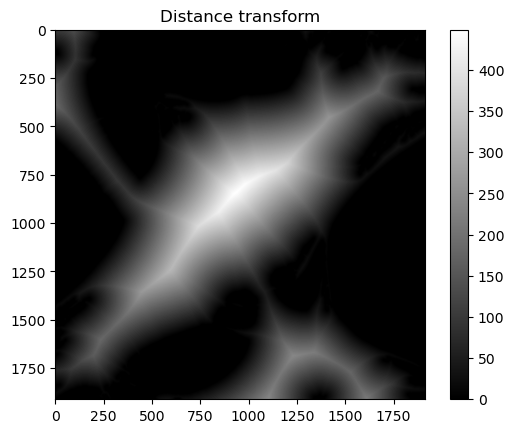

In [33]:
distance = ndi.distance_transform_edt(actin_mask) 

plt.imshow(distance, cmap=plt.cm.gray)
plt.title('Distance transform')
plt.colorbar()
plt.show()

#### IV.3.4. Watershed ####
Now we set the nuclei we segemented before as the markers or seeds of the segmentations. We use the markers to label the segmented regions in the actin region. 
After, we watershed the negative inverse of the distance transform of the actin using the defined markers and within the mask delimited by the actin. The negative inverse of the distance is used in the watershed function instead of the distance because the goal is to have the objects region as valleys not peak.  

Text(0.5, 1.0, 'Segmented ROIs')

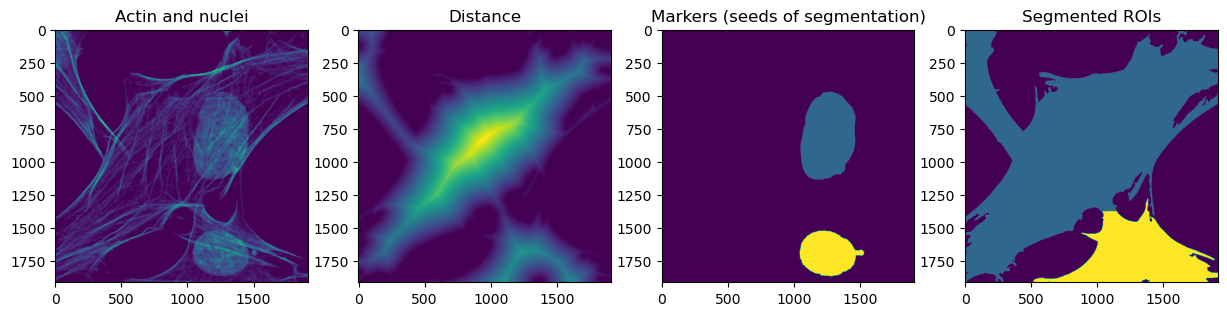

In [34]:
watershed_ROIs_image = watershed(-distance, markers=nuclei_label_image, mask=actin_mask)

fig, axs = plt.subplots(1,4, figsize=(15, 15))
axs[0].imshow(actin+nuclei)
axs[0].set_title('Actin and nuclei')

axs[1].imshow(distance)
axs[1].set_title('Distance')

axs[2].imshow(nuclei_label_image)
axs[2].set_title('Markers (seeds of segmentation)')

axs[3].imshow(watershed_ROIs_image)
axs[3].set_title('Segmented ROIs')


## VI.4. Spot detection ##

To do the spot detection, we need to use what is called blob detection. Blob stands for Binary Large Object and refers to the connected pixel in the binary image. The blob detection method aims at detecting regions in a digital image that differ in properties, such as brightness or color, compared to surrounding regions. The Difference of Gaussian (DoG) method is one technique to detect blobs. For each blob found (a spot in our case), the method returns its coordinates position and the standard deviation of the Gaussian kernel that detected the spot. 

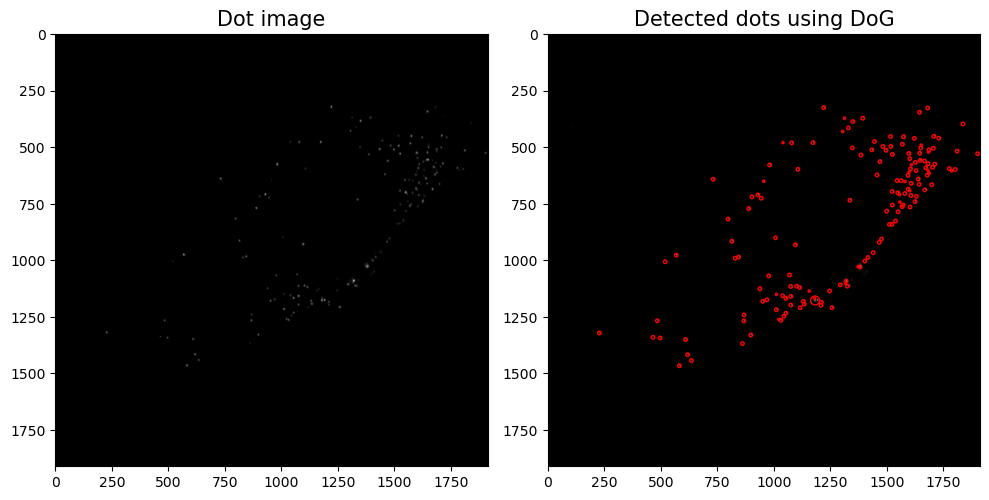

In [47]:
dotsimage = myimg[2,:,:] # the image containing the dot spot we want to detect

# Difference of Gaussian (DOG)
y_x_sigmas_dots = blob_dog(dotsimage, max_sigma=10, threshold=0.01) # 

# Display results
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].set_title('Dot image',fontsize=15)
ax[0].imshow(dotsimage,cmap='gray')

ax[1].imshow(dotsimage, cmap='gray') # same image on which the circle is to overlay on
for coord in y_x_sigmas_dots:
    y, x, sigma = coord              # outputs of the DoG blob detection: y,x coordinates and std of the Gaussian kernel
    ax[1].add_patch(plt.Circle((x, y), sigma*3, color='r',  # display of the circle centered at the (y,x) coordinates and with radius sigma*3
                            fill=False))
ax[1].set_title('Detected dots using DoG',fontsize=15)

plt.tight_layout()
plt.show()

## V. Measurement ##
Now let use the ROI masks that we have just segmented and do the measurement we previously defined as our problems. For this, we use the regionprops function to measure the properties of the signal within the ROI mask. Below we display the countours of the ROIs.

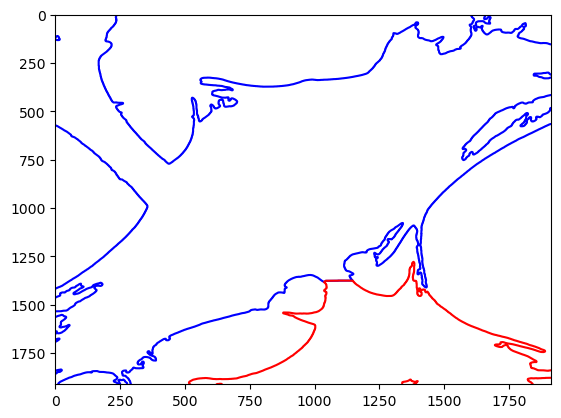

In [35]:
props = regionprops(watershed_ROIs_image,actin) # signal property: first argument is the mask ROI, second argument is the signal from which we are to extract any information of interest from

color_list = ['blue', 'red'] # to distinguish the countours of the two regions 

color_indx = 0

for p in props:
    c = find_contours(watershed_ROIs_image==p.label,0.5)
    for ck in c:
        plt.plot(ck[:,1],ck[:,0], color=color_list[color_indx])
    color_indx = color_indx + 1
plt.xlim(0, actin.shape[0])
plt.ylim(0, actin.shape[1])
plt.gca().invert_yaxis()

### V.1. Measure the maximal intensity in Channel-0 within the ROI ###

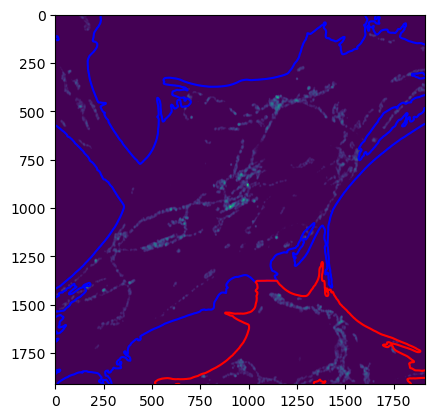

The maximal intensity for each regions are:  [19.0, 12.0]


In [36]:
signal = myimg[0,:,:] # the signal from which we want to do the measurement from
props = regionprops(watershed_ROIs_image, signal)

# let display them to be sure we are selecting the right mask and the right signal

plt.imshow(signal)

color_indx = 0

for p in props:
    c = find_contours(watershed_ROIs_image==p.label,0.5)
    for ck in c:
        plt.plot(ck[:,1],ck[:,0], color=color_list[color_indx])
    color_indx = color_indx + 1
plt.show()

# measure the maximal intensity
list_max_int = [p.intensity_max for p in props]
print('The maximal intensity for each regions are: ',list_max_int)

### V.2. Measure the integrated intensity in Channel-1 within the ROI ###
In this measurement, we need to find the integrated intensity within the channel of our interest. It is not straightforward as for calculating the maximal intensity or mean but firstly we need to find the image intensity. Then we sum those intensity values to obtain the integrated intensity. 

Display signal overlayed with the ROI masks:


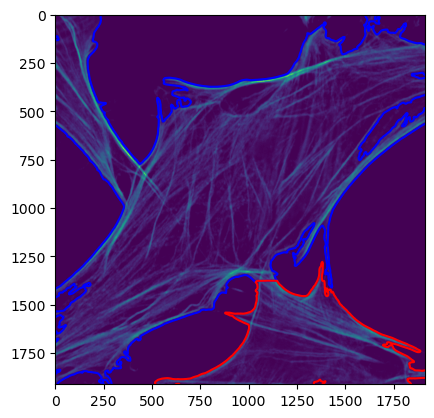

Display image intensity:


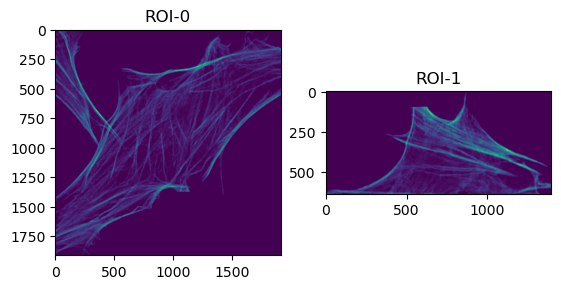

The integrated intensity for each regions are:  [8008674, 1638966]


In [37]:
signal = myimg[1,:,:] # the signal from which we want to do the measurement from
props = regionprops(watershed_ROIs_image, signal)

# let display them to be sure we are selecting the right mask and the right signal
print('Display signal overlayed with the ROI masks:')
plt.imshow(signal) # add a colormap into the signal here to differentiate the countour from the signal if necessary by adding for example: cmap = 'Reds'

color_indx = 0

for p in props:
    c = find_contours(watershed_ROIs_image==p.label,0.5)
    for ck in c:
        plt.plot(ck[:,1],ck[:,0], color=color_list[color_indx])
    color_indx = color_indx + 1
plt.show()

print('Display image intensity:')

number_regions = len(props)
fig, axs = plt.subplots(1, number_regions)
k = 0 # initialize the 
list_integrated_int = [] # this the list where we want to store the values of the integrated intensity
for p in props:
    iint = p.image_intensity # extract the image intensity within the ROI
    list_integrated_int.append(np.sum(iint))
    axs[k].imshow(iint)
    axs[k].set_title('ROI-'+str(k))
    k=k+1 
plt.show()
# fig.set_size_inches(10, 1000)

print('The integrated intensity for each regions are: ',list_integrated_int)

### V.3. Measure the median intensity in Channel-2 within the ROI ###
The information about the median is also not included in the image property that we can retrieve from regionprops. So here we show how can we do it using the information we can extract from the regionprops and numpy. The median of a list is defined as the middle element of the list when the list is sorted. We will compute a simple list below to illustrate how it works.

In [38]:
# example of median
l=[1,100,5,0,0,200,1000]    # list : change the values if needed
l2=sorted(l)                # sorted list 
print('sorted list: ',l2)   # display the sorted list
print('median value of the list l: ', np.median(l))         # display the median value

sorted list:  [0, 0, 1, 5, 100, 200, 1000]
median value of the list l:  5.0


Display signal overlayed with the ROI masks


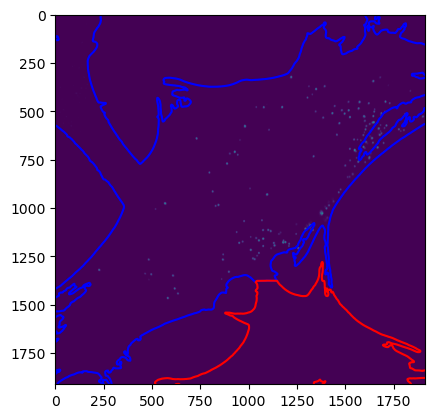

The median intensity for each regions are:  [0.0, 0.0]


In [67]:
signal = myimg[2,:,:] # the signal from which we want to do the measurement from
props = regionprops(watershed_ROIs_image, signal)

# let display them to be sure we are selecting the right mask and the right signal
print('Display signal overlayed with the ROI masks')
plt.imshow(signal) # the signal from which we want to measure the median 

color_indx = 0

for p in props:
    c = find_contours(watershed_ROIs_image==p.label,0.5)
    for ck in c:
        plt.plot(ck[:,1],ck[:,0], color=color_list[color_indx])
    color_indx = color_indx + 1
plt.show()

M=np.arange(len(props)) # indexes of the segmented regions
list_median_int=[np.median(signal[props[m].coords[:,0],props[m].coords[:,1]]) for m in M]

print('The median intensity for each regions are: ',list_median_int)

### V.4. Measure the number of dots in Channel-2 within the ROI ###
Now we are going to count how many dots are there in Channel-2 within the two regions defined by the ROIs. We use the use knowledge we have acquired from Section. Spot detection to complete this task.


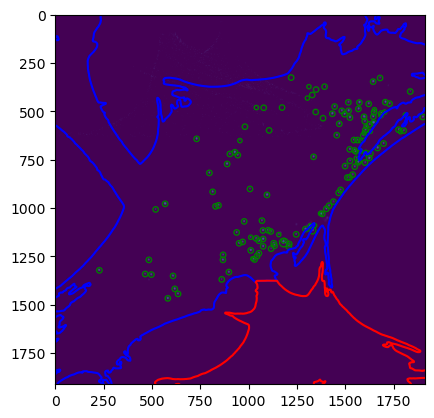

The number of dots in each regions are:  [137, 0]


In [88]:
signal = myimg[2,:,:] # the signal from which we want to do the measurement from
props = regionprops(watershed_ROIs_image, signal)

dots_number = [] # list where we want to store the number of dots of each ROI

color_indx = 0

for p in props:
    iint = p.image_intensity # extract the image intensity within each of the ROIs
    y_x_sigmas_dots_ROI = blob_dog(iint, max_sigma=10, threshold=0.01) # detect the dots in the ROI
    dots_number.append(y_x_sigmas_dots_ROI.shape[0]) # the number of coordinates position gives us the number of dots

    c = find_contours(watershed_ROIs_image==p.label,0.5)
    for ck in c:
        plt.plot(ck[:,1],ck[:,0], color=color_list[color_indx])
    
    plt.imshow(iint)
    plt.scatter(y_x_sigmas_dots_ROI[:,1], y_x_sigmas_dots_ROI[:,0], 6*y_x_sigmas_dots_ROI[:,2], facecolors='none', edgecolor='green')

    color_indx = color_indx+1

plt.show()


print('The number of dots in each regions are: ', dots_number)
     

## VI. Generate a table to display the results ##
Now let save the results! We will need the pandas package for this.

In [89]:
import pandas as pd
plc_data = pd.DataFrame(columns=['Maximal_intensity','Integrated_intensity', 'Median','Spot number'], dtype=object) # create a table
data = {'Maximal_intensity':list_max_int,'Integrated_intensity': list_integrated_int, 'Median': list_median_int, 'Spot number':dots_number}
plc_data = pd.DataFrame(data=data)
plc_data

,Maximal_intensity,Integrated_intensity,Median,Spot number
0,19.0,8008674,0.0,137
1,12.0,1638966,0.0,0


## VIII. Save results in an excel sheet ##

In [90]:
destinationfile='C:/Users/Dina Ratsimandresy/Documents/MRC-Office/Dataset/course/new_discovery.xlsx'
sheet_name='first_try'
plc_data.to_excel(destinationfile, sheet_name, index=False)